# Modelo 1 Random Forest con todas las variables y GridSearch

### Carga y división de datos

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [84]:
# Carga de los datos
df_ingresos_m1 = pd.read_csv('../Datos/Procesados/income.csv')
df_ingresos_m1.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
# División de datos
X = df_ingresos_m1.drop(columns=['income'])
y = df_ingresos_m1.income

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Creación del pipeline

In [86]:
# Dividir columnas
columnas_categoricas = X.select_dtypes(include='object').columns.tolist()

# Preprocesador con OneHotEncoder
preprocesador = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), columnas_categoricas)
    ], remainder='passthrough'
)

In [87]:
# Pipeline
pipeline = Pipeline(steps=[
    ('preprocesamiento', preprocesador),
    ('modelo', RandomForestClassifier(random_state=42))
])

In [88]:
# Malla de hiperparámetrosSearchC
malla_hiperparametros = {
    'modelo__n_estimators' : [100, 200],
    'modelo__max_depth' : [None, 10, 20],
    'modelo__min_samples_split' : [2, 5],
    'modelo__min_samples_leaf' : [1, 2]
}

In [89]:
# Creación de Gridsearch
grid = GridSearchCV(
    estimator = pipeline,
    param_grid = malla_hiperparametros,
    cv = 5,
    scoring = 'accuracy',
    n_jobs = 1,
    verbose = 1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('modelo',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=1,
             param_grid={'modelo__max_depth': [None, 10, 20],
                         'modelo__min_samples_leaf': [1, 2],
                         'modelo__min_samples_split': [2, 5],
                         'modelo__n_estimators': [100, 200]},
             scoring='accuracy', verbose=1)

In [95]:
# Mejores hiperparámetros
print("Mejores parámetros:", grid.best_params_)

# Mejor score en validación cruzada
print("Mejor score Validación cruzada:", grid.best_score_)

# Evaluación sobre el test set
mejor_modelo = grid.best_estimator_
accuracy_test = mejor_modelo.score(X_test, y_test)
print("Accuracy en test set:", accuracy_test)

Mejores parámetros: {'modelo__max_depth': None, 'modelo__min_samples_leaf': 2, 'modelo__min_samples_split': 5, 'modelo__n_estimators': 200}
Mejor score Validación cruzada: 0.8637134753853234
Accuracy en test set: 0.8678028558268079


### Evaluación del modelo

In [ ]:
mejor_modelo.fit(X_train, y_train)
y_train_pred = mejor_modelo.predict(X_train)
y_test_pred = mejor_modelo.predict(X_test)

In [97]:
#Calculo el accuracy en Train
train_accuracy_tree = accuracy_score(y_train, y_train_pred)

#Calculo el accuracy en Test
test_accuracy_tree = accuracy_score(y_test, y_test_pred)

print('Accuracy train:', train_accuracy_tree)
print('Accuracy test:', test_accuracy_tree)

Accuracy train: 0.9060964373464373
Accuracy test: 0.8678028558268079


In [98]:
# Clasification report
reporte = classification_report(y_test, y_test_pred)
print(reporte)

              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.92      4942
        >50K       0.78      0.63      0.70      1571

    accuracy                           0.87      6513
   macro avg       0.83      0.79      0.81      6513
weighted avg       0.86      0.87      0.86      6513



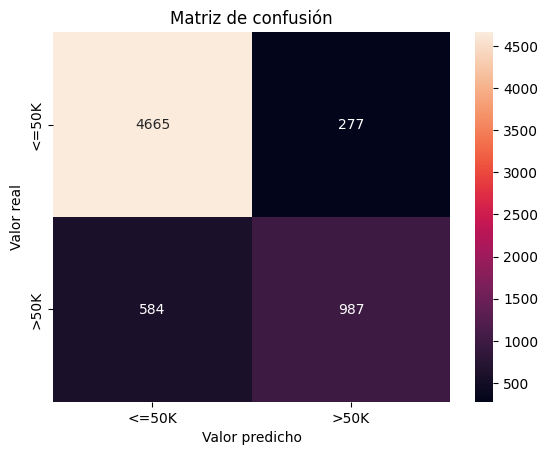

In [99]:
matriz_confusion = confusion_matrix(y_test, y_test_pred)
sns.heatmap(matriz_confusion, annot=True, fmt='d', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel("Valor predicho")
plt.ylabel("Valor real")
plt.title("Matriz de confusión")
plt.show();